# **Stage 1: Data Preprocessing**

In this stage, we preprocess the raw data to ensure it is in the appropriate format for analysis and modeling. The main tasks performed include:

1. **Loading the Data**:  
   The data is loaded from an Excel file (`niteroi.xlsx`) and converted into a Pandas DataFrame. 

2. **Format Conversion**: 
   - Replacing commas with periods in numeric columns.  
   - Converting columns to appropriate data types (e.g., numeric, datetime).

3. **Data Cleaning**:
   - Removing unnecessary suffixes (e.g., "UTC" in the time column).  
   - Creating derived variables, such as month and season.  

4. **Handling Missing Values**:  
   - Identifying and treating missing values, including creating a binary variable to indicate precipitation occurrence.  

5. **Column Filtering**:  
   - Selecting relevant columns for analysis and modeling.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import classification_report, accuracy_score

In [2]:
# Load the dataset
file_path = 'niteroi.xlsx'
df = pd.read_excel(file_path)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 19 columns):
 #   Column                                                 Non-Null Count  Dtype         
---  ------                                                 --------------  -----         
 0   Data                                                   8784 non-null   datetime64[ns]
 1   Hora UTC                                               8784 non-null   object        
 2   PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                       8496 non-null   float64       
 3   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  8496 non-null   float64       
 4   PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)        8483 non-null   float64       
 5   PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)       8483 non-null   float64       
 6   RADIACAO GLOBAL (Kj/m²)                                4635 non-null   float64       
 7   TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)           8496 non-null 

In [4]:
# Conversion of Formats

cols_to_convert = df.columns[2:]  

for col in cols_to_convert:
    # Replace commas with periods (for decimal numbers)
    df[col] = df[col].astype(str).str.replace(',', '.', regex=False)
    # Convert to numeric, coercing errors to NaN (e.g., invalid strings)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Cleaning the "Hora UTC" Column

# Remove 'UTC' and convert to time format
df['Hora UTC'] = df['Hora UTC'].str.replace(' UTC', '', regex=False)  # Remove 'UTC' suffix
# Convert to datetime format (assuming the input is in 'HHMM' format)
df['Hora UTC'] = pd.to_datetime(df['Hora UTC'], format='%H%M').dt.strftime('%H:%M')  # Convert to 'HH:MM' format

In [5]:
# Summary of Column Names

rename_dict = {
    'Data': 'DATE',
    'Hora UTC': 'TIME',
    'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)': 'TOTAL_PRECIPITATION',
    'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)': 'ATMOSPHERIC_PRESSURE',
    'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)': 'MAX_ATMOSPHERIC_PRESSURE',
    'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)': 'MIN_ATMOSPHERIC_PRESSURE',
    'RADIACAO GLOBAL (Kj/m²)': 'GLOBAL_RADIATION',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)': 'AIR_TEMPERATURE',
    'TEMPERATURA DO PONTO DE ORVALHO (°C)': 'DEW_POINT_TEMPERATURE',
    'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)': 'MAX_TEMPERATURE',
    'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)': 'MIN_TEMPERATURE',
    'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)': 'MAX_DEW_POINT_TEMPERATURE',
    'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)': 'MIN_DEW_POINT_TEMPERATURE',
    'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)': 'MAX_HUMIDITY',
    'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)': 'MIN_HUMIDITY',
    'UMIDADE RELATIVA DO AR, HORARIA (%)': 'RELATIVE_HUMIDITY',
    'VENTO, DIREÇÃO HORARIA (gr) (° (gr))': 'WIND_DIRECTION',
    'VENTO, RAJADA MAXIMA (m/s)': 'MAX_WIND_GUST',
    'VENTO, VELOCIDADE HORARIA (m/s)': 'WIND_SPEED'
}

# Rename the columns in the DataFrame
df.rename(columns=rename_dict, inplace=True)

In [6]:
# Create a "month" column
df['MONTH'] = df['DATE'].dt.month

# Create a "season" column based on the month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Summer'
    elif month in [3, 4, 5]:
        return 'Autumn'
    elif month in [6, 7, 8]:
        return 'Winter'
    else:
        return 'Spring'

df['SEASON'] = df['MONTH'].apply(get_season)

# Binary variable to indicate if there was precipitation (1 if > 0, 0 if == 0, and NaN if NaN)
df['RAIN'] = df['TOTAL_PRECIPITATION'].apply(lambda x: 1 if x > 0 else (0 if x == 0 else pd.NA))
df['RAIN'] = pd.to_numeric(df['RAIN'])

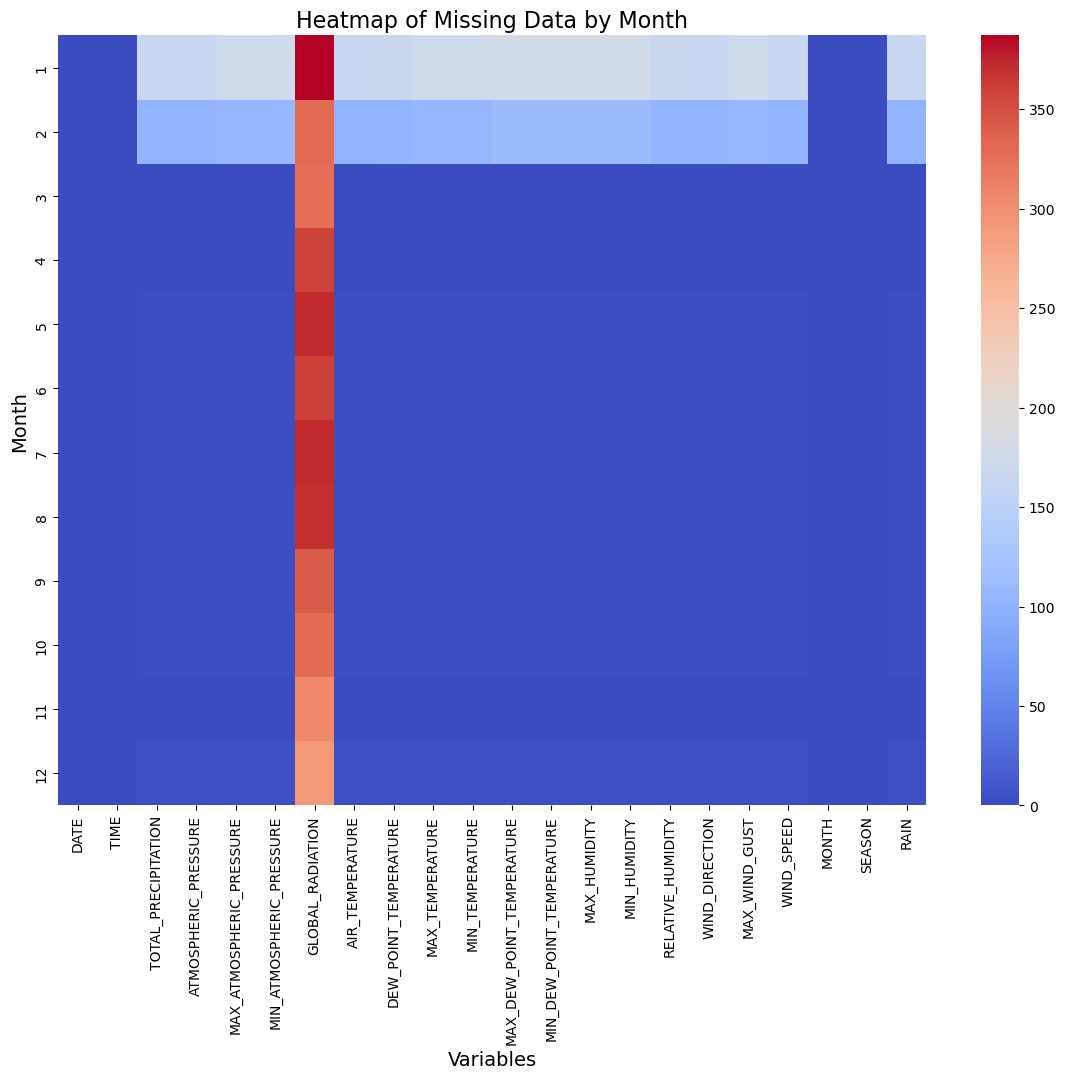

In [7]:
# Heatmap of Missing Data by Month

# Set the figure size
plt.figure(figsize=(14, 10))

# Create a heatmap of missing data grouped by month
sns.heatmap(df.isnull().groupby(df['MONTH']).sum(), cmap='coolwarm', cbar=True)

# Add title and labels
plt.title('Heatmap of Missing Data by Month', fontsize=16)
plt.xlabel('Variables', fontsize=14)
plt.ylabel('Month', fontsize=14)

# Display the plot
plt.show()

In [8]:
# Filtering the Desired Columns

# List of desired columns (using English column names)
desired_columns = [
    'DATE', 'TIME', 'TOTAL_PRECIPITATION', 'RAIN',
    'ATMOSPHERIC_PRESSURE', 'MAX_ATMOSPHERIC_PRESSURE', 'MIN_ATMOSPHERIC_PRESSURE',
    'AIR_TEMPERATURE', 'DEW_POINT_TEMPERATURE', 'RELATIVE_HUMIDITY',
    'WIND_DIRECTION', 'WIND_SPEED',
    'MONTH', 'SEASON'
]

# Filter the DataFrame to include only the desired columns
df_filtered = df[desired_columns]
df_filtered.to_excel('df_filtered.xlsx', index=False)

# **Stage 2: Exploratory Data Analysis (EDA)**

In this stage, we perform an in-depth exploration of the cleaned and preprocessed data to uncover patterns, trends, and relationships between variables. The goal of EDA is to gain insights into the data that will guide the modeling process and ensure that the features used are meaningful and relevant.

### **Key Steps in EDA**:
1. **Distribution of Variables**:  
   We analyze the distribution of numeric variables to understand their spread, skewness, and potential outliers. This helps identify whether transformations (e.g., log, normalization) are needed.

2. **Correlation Analysis**:  
   We examine the correlation between variables to identify relationships and potential multicollinearity. This step is crucial for selecting features that contribute meaningfully to the target variable.

3. **Seasonal Patterns**:  
   We explore how precipitation and other variables vary across seasons and months. This helps capture seasonal trends that may influence the target variable.

4. **Class Imbalance Analysis**:  
   We assess the balance of the target variable (**RAIN**) and identify strategies to address class imbalance, such as oversampling or undersampling techniques.

5. **Feature Engineering**:  
   Based on the insights from EDA, we create new features (e.g., seasonal indicators, rainy month flags) to improve the model's predictive power.

In [9]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   DATE                      8784 non-null   datetime64[ns]
 1   TIME                      8784 non-null   object        
 2   TOTAL_PRECIPITATION       8496 non-null   float64       
 3   RAIN                      8496 non-null   float64       
 4   ATMOSPHERIC_PRESSURE      8496 non-null   float64       
 5   MAX_ATMOSPHERIC_PRESSURE  8483 non-null   float64       
 6   MIN_ATMOSPHERIC_PRESSURE  8483 non-null   float64       
 7   AIR_TEMPERATURE           8496 non-null   float64       
 8   DEW_POINT_TEMPERATURE     8493 non-null   float64       
 9   RELATIVE_HUMIDITY         8493 non-null   float64       
 10  WIND_DIRECTION            8495 non-null   float64       
 11  WIND_SPEED                8495 non-null   float64       
 12  MONTH               

In [10]:
df_filtered.describe()

,TOTAL_PRECIPITATION,RAIN,ATMOSPHERIC_PRESSURE,MAX_ATMOSPHERIC_PRESSURE,MIN_ATMOSPHERIC_PRESSURE,AIR_TEMPERATURE,DEW_POINT_TEMPERATURE,RELATIVE_HUMIDITY,WIND_DIRECTION,WIND_SPEED,MONTH
count,8496.000000,8496.000000,8496.00000,8483.000000,8483.000000,8496.000000,8493.000000,8493.000000,8495.000000,8495.000000,8784.000000
mean,0.121210,0.063677,1015.21496,1015.462537,1014.973736,25.401707,19.510409,72.621217,182.542672,1.334197,6.513661
std,1.100579,0.244191,4.47169,4.453059,4.485556,4.119863,3.356469,18.330298,98.172456,0.952636,3.451430
min,0.000000,0.000000,1003.00000,1003.900000,1002.900000,12.900000,5.400000,16.000000,1.000000,0.100000,1.000000
25%,0.000000,0.000000,1012.20000,1012.500000,1011.900000,22.500000,17.300000,60.000000,92.000000,0.600000,4.000000
50%,0.000000,0.000000,1014.80000,1015.100000,1014.600000,25.000000,19.700000,73.000000,191.000000,1.100000,7.000000
75%,0.000000,0.000000,1018.00000,1018.200000,1017.700000,28.000000,22.000000,89.000000,259.000000,1.800000,10.000000
max,53.000000,1.000000,1028.00000,1028.100000,1028.000000,39.900000,27.400000,97.000000,360.000000,7.600000,12.000000


<Figure size 1500x1000 with 0 Axes>

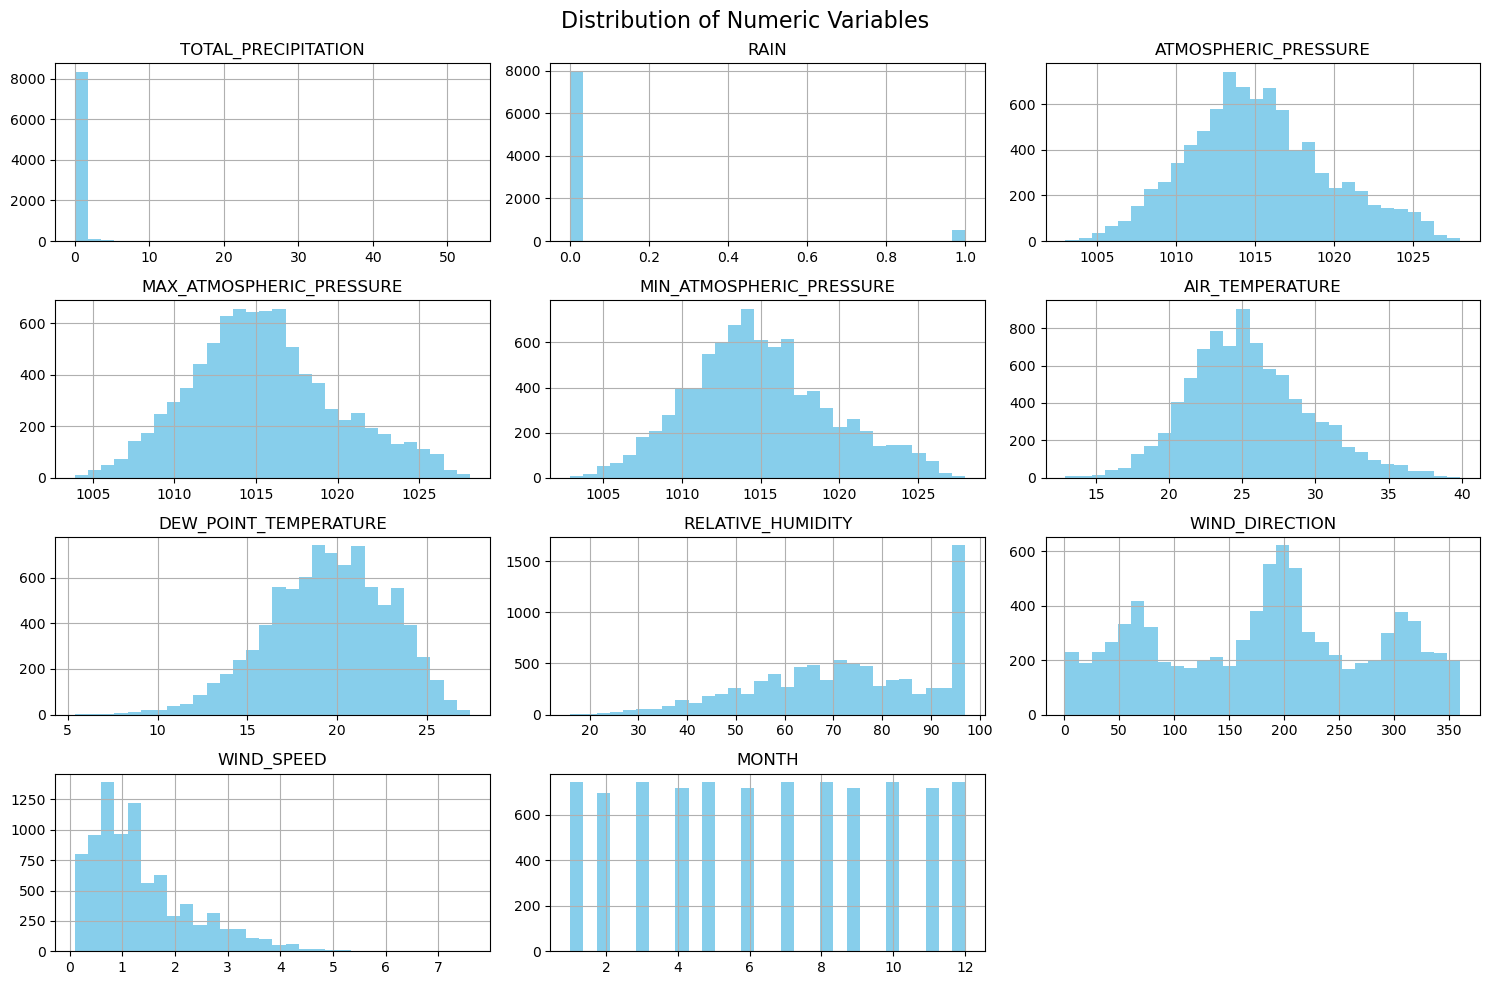

In [11]:
# Distribution of Numeric Variables
plt.figure(figsize=(15, 10))
df_filtered.select_dtypes(include=['float64', 'int64']).hist(bins=30, figsize=(15, 10), color='skyblue')
plt.suptitle('Distribution of Numeric Variables', fontsize=16)
plt.tight_layout()
plt.show()

## Distribution of Variables

- Most numeric variables have an approximately normal distribution, except for **TOTAL_PRECIPITATION**, **RAIN**, and **WIND_SPEED**, which are skewed.
- Variables such as **ATMOSPHERIC_PRESSURE**, **AIR_TEMPERATURE**, and **RELATIVE_HUMIDITY** have well-behaved distributions, making them easier to model.

## Class Balance

- The target variable (**RAIN**) is highly imbalanced, with most values being 0.
- Class balancing techniques should be considered during modeling.

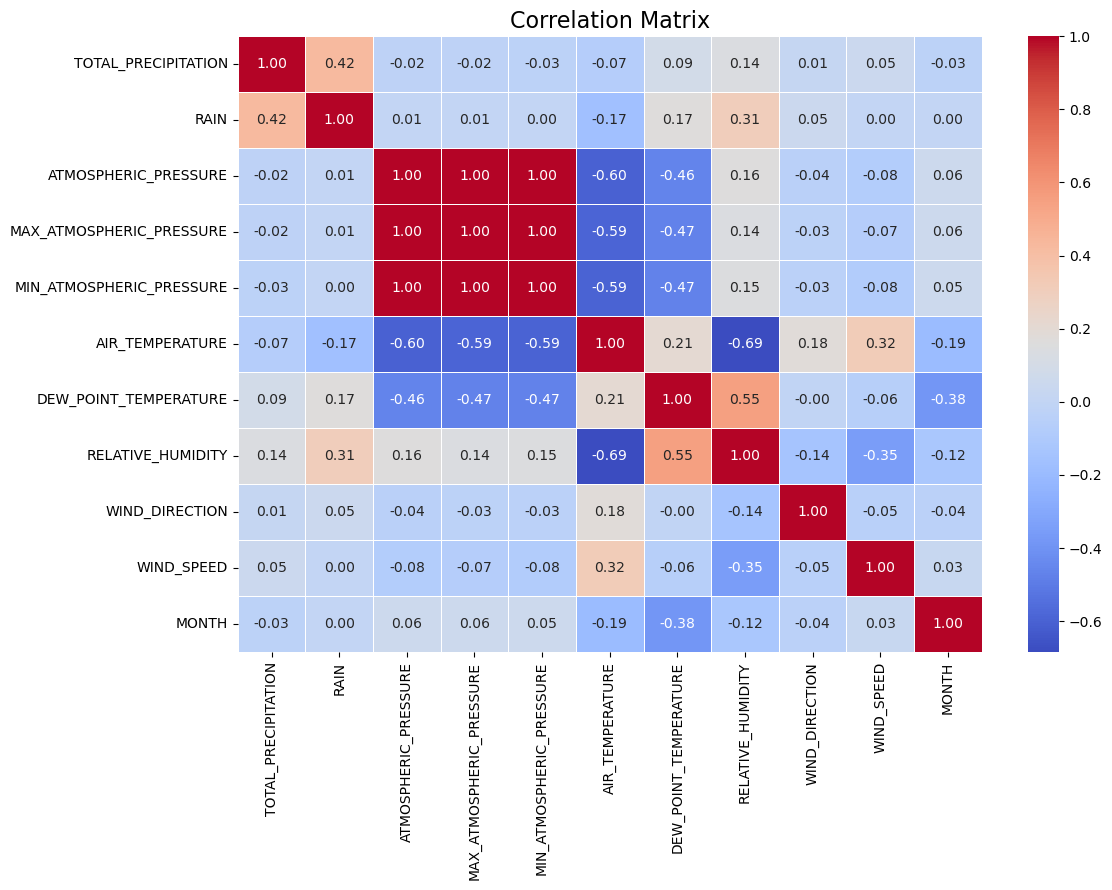

In [12]:
# Correlation Matrix
plt.figure(figsize=(12, 8))
corr = df_filtered.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

## Most Relevant Variables for Predicting Rain

- **RELATIVE_HUMIDITY**: Has the highest positive correlation with **RAIN** (0.31) and is the most important variable for predicting rain occurrence.
- **DEW_POINT_TEMPERATURE**: Has a weak positive correlation (0.17) and can also be useful.
- **AIR_TEMPERATURE**: Has a weak negative correlation (-0.17), suggesting that higher temperatures are associated with a lower chance of rain.

## Variables with Multicollinearity

- **ATMOSPHERIC_PRESSURE**, **MAX_ATMOSPHERIC_PRESSURE**, and **MIN_ATMOSPHERIC_PRESSURE** have perfect correlation with each other.
- Only one of them should be used in the model to avoid multicollinearity.

## Variables with Little to No Correlation

- **WIND_DIRECTION**, **WIND_SPEED**, and **MONTH** have very weak or almost no correlation with **TOTAL_PRECIPITATION** and **RAIN**.
- These variables may not be useful for the model.

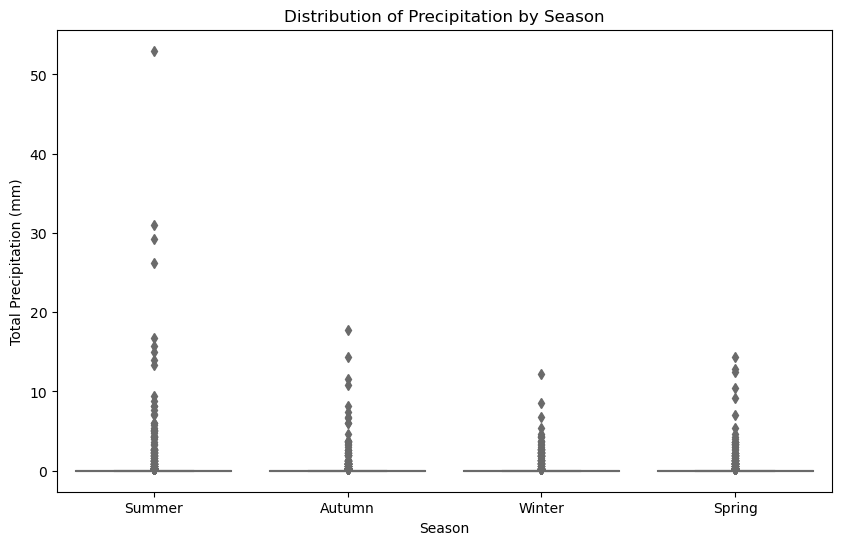

In [13]:
# Precipitation Analysis by Season
plt.figure(figsize=(10, 6))
sns.boxplot(x='SEASON', y='TOTAL_PRECIPITATION', data=df_filtered, palette='Set3')
plt.title('Distribution of Precipitation by Season')
plt.ylabel('Total Precipitation (mm)')
plt.xlabel('Season')
plt.show()

## Seasonal Pattern

- There is a clear seasonal pattern in precipitation, with **summer** being the rainiest season and **winter** the driest.
- **Spring** and **autumn** are transitional seasons, with intermediate levels of precipitation.

## Implications for the Model

- The season (**SEASON**) is an important feature for predicting rain, as it captures seasonal patterns.
- The model can benefit from including **SEASON** as a categorical variable.

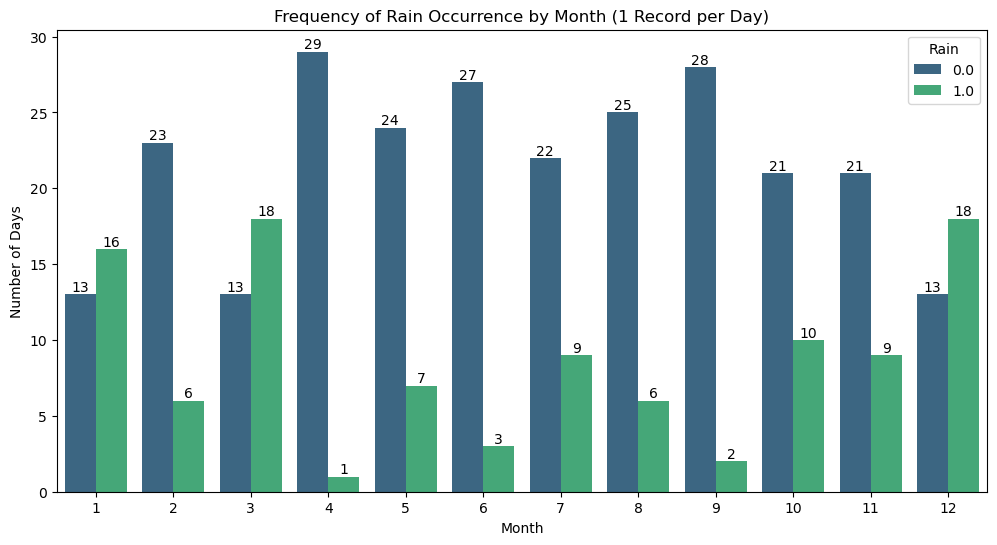

In [14]:
# Create a dataframe with only one entry per day
df_daily = df_filtered.groupby('DATE').agg({'RAIN': 'max', 'MONTH': 'first'}).reset_index()

# Create the count plot
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='MONTH', hue='RAIN', data=df_daily, palette='viridis')

# Add the number of occurrences on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black')

plt.title('Frequency of Rain Occurrence by Month (1 Record per Day)')
plt.xlabel('Month')
plt.ylabel('Number of Days')
plt.legend(title='Rain', loc='upper right')
plt.show()

## Class Imbalance

- The target variable (**RAIN**) is highly imbalanced across all months, with most days being **rain-free**.
- Class balancing techniques (e.g., **SMOTE, oversampling**) should be applied to ensure the model is not biased toward the majority class (**rain-free**).

## Seasonal Pattern

- The occurrence of rain varies across months, with some months being rainier than others.
- The **month** or **season** are important features for capturing this seasonal pattern.

## Feature Engineering

Create derived features related to **season**:

- **SEASON_INDICATOR**: Encode the season (**summer, autumn, winter, spring**) as categorical variables.

# **Stage 3: Data Preparation for Modeling**

In this stage, we prepare the dataset for machine learning modeling by addressing key issues such as missing values, class imbalance, and feature encoding. The goal is to create a clean, balanced, and well-structured dataset that can be used to train and evaluate predictive models effectively.

### **Key Steps in This Stage**:
1. **Handling Missing Values**:  
   - Remove rows with missing values in the target variable (**RAIN**).  
   - Replace or remove missing values in the feature variables (**X**) to ensure the dataset is complete.

2. **Encoding Categorical Variables**:  
   - Apply **One-Hot Encoding** to the categorical variable **SEASON** to convert it into a format suitable for machine learning algorithms.

3. **Class Imbalance Treatment**:  
   - Use **SMOTE (Synthetic Minority Oversampling Technique)** to balance the target variable (**RAIN**), ensuring the model is not biased toward the majority class (rain-free days).

4. **Final Dataset Preparation**:  
   - Combine the resampled features and target variable into a final balanced dataset.  
   - Verify the distribution of the target variable after balancing.

### **Outcomes of This Stage**:
- A clean and balanced dataset ready for modeling.  
- Features encoded in a format suitable for machine learning algorithms.  
- A target variable with balanced classes, improving the model's ability to learn from both rain and rain-free days.

By the end of this stage, the dataset will be fully prepared for the next step: **Model Training and Evaluation**.

---

### **Next Steps**:
- Split the dataset into training and testing sets.  
- Train machine learning models (e.g., logistic regression, random forest).  
- Evaluate model performance using appropriate metrics (e.g., accuracy, precision, recall, F1-score).

In [15]:
# Selection of necessary columns
selected_columns = ['AIR_TEMPERATURE', 'DEW_POINT_TEMPERATURE', 'RELATIVE_HUMIDITY', 'ATMOSPHERIC_PRESSURE', 'SEASON', 'RAIN']

# Filter the dataframe to include only the selected columns
df_model = df_filtered[selected_columns].copy()

# Apply One-Hot Encoding to the 'SEASON' variable
encoder = OneHotEncoder(drop='first')  # drop='first' to avoid multicollinearity
seasons_encoded = encoder.fit_transform(df_model[['SEASON']])
season_labels = encoder.get_feature_names_out(['SEASON'])  

# Create a new DataFrame with the one-hot encoded columns
df_seasons = pd.DataFrame(seasons_encoded.toarray(), columns=season_labels, index=df_model.index)

# Concatenate with the original dataframe (removing the old categorical column)
df_model = pd.concat([df_model.drop(columns=['SEASON']), df_seasons], axis=1)

In [16]:
df_model.head()

,AIR_TEMPERATURE,DEW_POINT_TEMPERATURE,RELATIVE_HUMIDITY,ATMOSPHERIC_PRESSURE,RAIN,SEASON_Spring,SEASON_Summer,SEASON_Winter
0,25.0,17.5,63.0,1016.3,0.0,0.0,1.0,0.0
1,24.9,14.8,53.0,1016.7,0.0,0.0,1.0,0.0
2,24.7,14.1,52.0,1016.3,0.0,0.0,1.0,0.0
3,24.5,13.1,49.0,1016.2,0.0,0.0,1.0,0.0
4,24.7,14.7,54.0,1015.6,0.0,0.0,1.0,0.0


In [17]:
# Remove entries with NaN in the target variable 'RAIN'
df_model = df_model.dropna(subset=['RAIN'])

# Ensure 'RAIN' is of integer type 
df_model['RAIN'] = df_model['RAIN'].astype(int)

X = df_model.drop(columns=['RAIN']).copy()
y = df_model['RAIN'].copy()

# Remove NaNs in the features (X)
X = X.dropna()
y = y.loc[X.index]  # Ensure 'y' retains the same indices

# Check if there are still NaNs before running SMOTE
print(f"Total NaNs in X: {X.isna().sum().sum()}")
print(f"Total NaNs in y: {y.isna().sum()}")

# Balancing with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a new DataFrame with the balanced data
df_final = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['RAIN'])], axis=1)

# Display the new distribution of the target variable
print("Distribution after balancing:")
print(df_final['RAIN'].value_counts())

Total NaNs in X: 0
Total NaNs in y: 0
Distribution after balancing:
0    7952
1    7952
Name: RAIN, dtype: int64


In [18]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15904 entries, 0 to 15903
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   AIR_TEMPERATURE        15904 non-null  float64
 1   DEW_POINT_TEMPERATURE  15904 non-null  float64
 2   RELATIVE_HUMIDITY      15904 non-null  float64
 3   ATMOSPHERIC_PRESSURE   15904 non-null  float64
 4   SEASON_Spring          15904 non-null  float64
 5   SEASON_Summer          15904 non-null  float64
 6   SEASON_Winter          15904 non-null  float64
 7   RAIN                   15904 non-null  int32  
dtypes: float64(7), int32(1)
memory usage: 932.0 KB


# **Stage 4: Modeling and Evaluation**

In this stage, we train and evaluate machine learning models to predict the occurrence of rain (**RAIN**) based on the preprocessed and balanced dataset. The goal is to identify the best-performing model for this classification task.

### **Key Steps in This Stage**:
1. **Train-Test Split**:  
   - Split the dataset into training (80%) and testing (20%) sets, ensuring the class distribution is preserved using stratified sampling.

2. **Model Training**:  
   - Train three different models:  
     - **Random Forest**: A robust ensemble method that builds multiple decision trees and aggregates their results.  
     - **Gradient Boosting**: Another ensemble method that builds trees sequentially, correcting errors from previous trees.  
     - **Logistic Regression**: A simple yet effective linear model for binary classification.

3. **Model Evaluation**:  
   - Evaluate each model using the **classification report**, which includes metrics such as precision, recall, F1-score, and accuracy.  
   - Compare the models based on their **accuracy** to determine the best-performing one.

4. **Results Analysis**:  
   - Analyze the performance of each model to understand its strengths and weaknesses.  
   - Identify the model that generalizes best to unseen data.


In [19]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Model 1: Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Model 2: Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

# Model 3: Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Model Evaluation
print("Random Forest Metrics:")
print(classification_report(y_test, y_pred_rf))

print("Gradient Boosting Metrics:")
print(classification_report(y_test, y_pred_gb))

print("Logistic Regression Metrics:")
print(classification_report(y_test, y_pred_lr))

# Accuracy Comparison
acc_rf = accuracy_score(y_test, y_pred_rf)
acc_gb = accuracy_score(y_test, y_pred_gb)
acc_lr = accuracy_score(y_test, y_pred_lr)

print(f"Random Forest Accuracy: {acc_rf:.2%}")
print(f"Gradient Boosting Accuracy: {acc_gb:.2%}")
print(f"Logistic Regression Accuracy: {acc_lr:.2%}")

Random Forest Metrics:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      1591
           1       0.95      0.96      0.95      1590

    accuracy                           0.95      3181
   macro avg       0.95      0.95      0.95      3181
weighted avg       0.95      0.95      0.95      3181

Gradient Boosting Metrics:
              precision    recall  f1-score   support

           0       0.93      0.86      0.89      1591
           1       0.87      0.93      0.90      1590

    accuracy                           0.89      3181
   macro avg       0.90      0.89      0.89      3181
weighted avg       0.90      0.89      0.89      3181

Logistic Regression Metrics:
              precision    recall  f1-score   support

           0       0.90      0.78      0.83      1591
           1       0.80      0.91      0.86      1590

    accuracy                           0.85      3181
   macro avg       0.85      0.85      0.84      

# **Stage 5: Hyperparameter Tuning and Final Model Evaluation**

In this stage, we optimize the **Random Forest** model using **GridSearchCV** to find the best hyperparameters and evaluate its performance on the test set. The goal is to improve the model's accuracy and generalization capability.

### **Key Steps in This Stage**:
1. **Hyperparameter Tuning**:  
   - Define a parameter grid for key hyperparameters such as `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`, and `bootstrap`.  
   - Use **GridSearchCV** with 5-fold cross-validation to find the best combination of hyperparameters.

2. **Training the Best Model**:  
   - Train the **Random Forest** model with the best hyperparameters identified by **GridSearchCV**.

3. **Model Evaluation**:  
   - Evaluate the tuned model on the test set using metrics such as **accuracy**, **classification report**, and **confusion matrix**.  
   - Analyze the results to understand the model's performance in terms of precision, recall, F1-score, and overall accuracy.

4. **Results Analysis**:  
   - Compare the performance of the tuned model with the baseline model to assess the impact of hyperparameter optimization.  
   - Identify areas for further improvement or additional tuning.


In [20]:
# Define the hyperparameters to be tested
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at a leaf node
    'bootstrap': [True, False]  # Whether to use bootstrap sampling
}

# Create the model
rf = RandomForestClassifier(random_state=42)

# Configure GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Train the model with optimized hyperparameters
grid_search.fit(X_train, y_train)

# Best combination of hyperparameters found
print("Best hyperparameters:", grid_search.best_params_)

# Evaluate on the test set
best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

# Print evaluation metrics
from sklearn.metrics import classification_report, accuracy_score
print("Tuned Random Forest Metrics:")
print(classification_report(y_test, y_pred_best_rf))
print(f"Tuned Random Forest Accuracy: {accuracy_score(y_test, y_pred_best_rf) * 100:.2f}%")

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best hyperparameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Tuned Random Forest Metrics:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1591
           1       0.94      0.96      0.95      1590

    accuracy                           0.95      3181
   macro avg       0.95      0.95      0.95      3181
weighted avg       0.95      0.95      0.95      3181

Tuned Random Forest Accuracy: 95.00%


In [21]:
# Get the best model from GridSearchCV
best_rf_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_rf_model.predict(X_test)

# Evaluate the model's performance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display results
print(f"Tuned Random Forest Test Accuracy: {accuracy:.4%}")
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n", conf_matrix)

Tuned Random Forest Test Accuracy: 95.0016%

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95      1591
           1       0.94      0.96      0.95      1590

    accuracy                           0.95      3181
   macro avg       0.95      0.95      0.95      3181
weighted avg       0.95      0.95      0.95      3181


Confusion Matrix:
 [[1499   92]
 [  67 1523]]


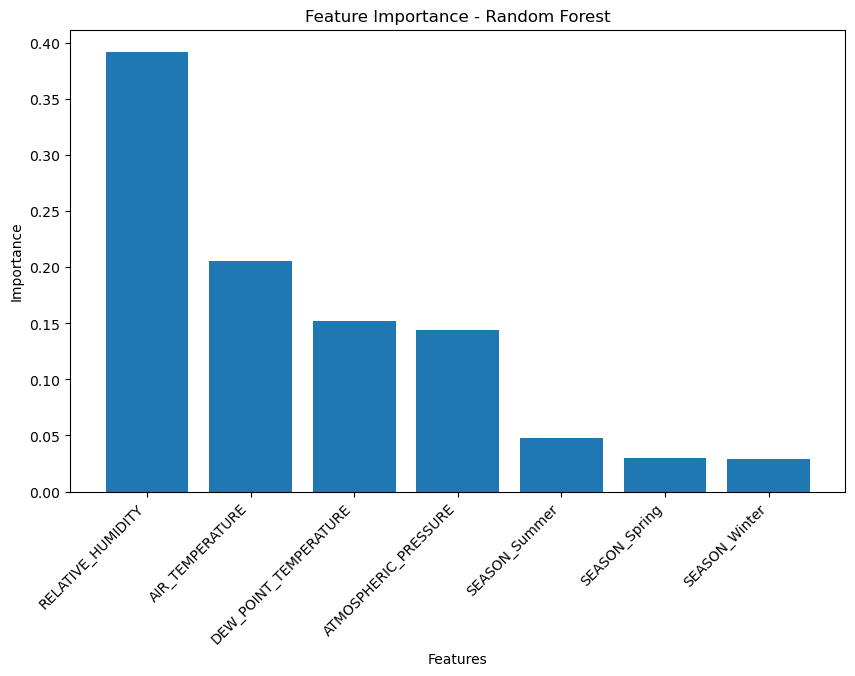

In [22]:
# Get feature importance
importances = best_rf_model.feature_importances_
feature_names = X_train.columns  # Feature names

# Sort features by importance
indices = np.argsort(importances)[::-1]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importance - Random Forest")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha="right")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()